In [8]:
#For Now I am strictly following the offical tensorflow guide to linear regression: https://www.youtube.com/watch?v=-vHQub0NXI4
#This is becuse I want to make sure I'm not screwing anything up; I will experiment later once I get this to work

In [15]:
import pathlib
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs
import pandas as pd

In [10]:
team_abbreviations = {
    "ATL": 1,
    "BKN": 2,
    "BOS": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,	
    "DEN": 8,
    "DET": 9,
    "GSW": 10,	
    "HOU": 11,	
    "IND": 12,
    "LAC": 13,	
    "LAL": 14,	
    "MEM": 15, 	
    "MIA": 16,	
    "MIL": 17,	
    "MIN": 18,	
    "NOP": 19,
    "NOH": 19,	
    "NYK": 20,	
    "OKC": 21,	
    "ORL": 22,	
    "PHI": 23,	
    "PHX": 24,	
    "POR": 25,	
    "SAC": 26,	
    "SAS": 27,	
    "TOR": 28,	
    "UTA": 29,	
    "WAS": 30
}

In [11]:
class Player(object):
    def __init__(self, PlayerID):
        
        self.PlayerID =  PlayerID 
        self.PlayerName = players.find_player_by_id(player_id=self.PlayerID)['full_name']

        self.StartYear = commonplayerinfo.CommonPlayerInfo(player_id= self.PlayerID).get_data_frames()[0]['FROM_YEAR'][0] 
        if self.StartYear < 2010:
            self.StartYear = 2010
        
            
        self.LastYear = 2019
        

    def compile_active_player_data(self):
        
        player_name = []
        points_scored_raw_data=[]
        game_date_raw_data = []
        win_loss_raw_data = []
        free_throws_raw_data = [] 
        feild_goals_2pts_raw_data = []
        feild_goals_3pts_raw_data = []
        matchup_raw_data = []
        location = []
        min_played_raw_data = []
        team_season_point_average_raw_data = []
        opponent_team_season_point_average_raw_data = []
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            playerLogs = playergamelogs.PlayerGameLogs(player_id_nullable=self.PlayerID, season_nullable=season)
            self.TeamID = playerLogs.get_data_frames()[0]["TEAM_ID"][0]
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            
            game_date_api_data = playerLogs.get_data_frames()[0]["GAME_DATE"]
            #win_loss_api_data = playerLogs.get_data_frames()[0]["WL"]
            free_throws_api_data = playerLogs.get_data_frames()[0]["FTM"]
            feild_goals_2pts_api_data = playerLogs.get_data_frames()[0]["FGM"]
            feild_goals_3pts_api_data = playerLogs.get_data_frames()[0]["FG3M"] 
            min_played_api_data = playerLogs.get_data_frames()[0]["MIN"]
            matchup_api_data = playerLogs.get_data_frames()[0]["MATCHUP"]

            print(playerLogs.get_data_frames()[0])


            
            
            


            #opponent_free_throws

            for game in range(0, len(game_date_api_data)):

                    self.TeamID = playerLogs.get_data_frames()[0]["TEAM_ID"][game]
                    team_free_throws_average_api_data = teamLogs.get_data_frames()[0]["FTM"].mean()
                    team_feild_goals_2pts_average_api_data = teamLogs.get_data_frames()[0]["FGM"].mean()
                    team_feild_goals_3pts_average_api_data = teamLogs.get_data_frames()[0]["FG3M"].mean()
                    team_season_point_average_api_data = ((team_free_throws_average_api_data) + (team_feild_goals_2pts_average_api_data*2) + (team_feild_goals_3pts_average_api_data*3))
                    team_season_point_average_raw_data.append(team_season_point_average_api_data)
                    player_name.append(self.PlayerName)
                    game_date_raw_data.append(game_date_api_data[game])
                    #win_loss_raw_data.append(win_loss_api_data[game])
                    #if (win_loss_api_data[game] == 'W'):
                       # win_loss_raw_data.append(1)
                    #elid
                    
                    
                    
                    #free_throws_raw_data.append(free_throws_api_data[game]) 
                    #feild_goals_2pts_raw_data.append(feild_goals_2pts_api_data[game])
                    #feild_goals_3pts_raw_data.append(feild_goals_3pts_api_data[game])
                    
                    
                    
                    points_scored_raw_data.append((free_throws_api_data[game])+(feild_goals_2pts_api_data[game]*2)+(feild_goals_3pts_api_data[game]*3))
                    
                    min_played_raw_data.append(min_played_api_data[game])

                    player_team_abbreviation= playerLogs.get_data_frames()[0]['TEAM_ABBREVIATION'][game]
                    if " vs. " in matchup_api_data[game]:
                        location.append(1)
                    elif "@" in matchup_api_data[game]:
                        location.append(2)

                    try:   
                        matchup_api_data[game] = matchup_api_data[game].replace(player_team_abbreviation, "")
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
    
                    matchup_api_data = matchup_api_data.replace('NOH', 'NOP')
                    matchup_api_data = matchup_api_data.replace('NJN', 'BKN')
                    #matchup_raw_data.append(matchup_api_data[game])
                    #print(777777777777777777, matchup_api_data[game] )
                    #print(8888888888, teams.find_team_by_abbreviation(matchup_api_data[game])["id"])
                    opponentAbbreviation = matchup_api_data[game]
                    matchup_api_data[game] = team_abbreviations[opponentAbbreviation]
                    matchup_raw_data.append(matchup_api_data[game])
                    #print(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    if (game%10==0):
                        print(game)
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    opponent_free_throws_average_api_data = opponentLogs.get_data_frames()[0]["FTM"].mean()
                    opponent_feild_goals_2pts_average_api_data = opponentLogs.get_data_frames()[0]["FGM"].mean()
                    opponent_feild_goals_3pts_average_api_data = opponentLogs.get_data_frames()[0]["FG3M"].mean()
                    opponent_season_point_average_api_data = ((opponent_free_throws_average_api_data) + (opponent_feild_goals_2pts_average_api_data*2) + (opponent_feild_goals_3pts_average_api_data*3))


                    opponent_team_season_point_average_raw_data.append(opponent_season_point_average_api_data)
                    time.sleep(1)
                    

        print("the lengths")
        print(len(player_name))
        print(len(min_played_raw_data))
        print(len(points_scored_raw_data))
        print(len(game_date_raw_data))
        #print(len(win_loss_raw_data))
        print(len(matchup_raw_data))
        print(len(location))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_team_season_point_average_raw_data))

        player_data = {
        "Player Name": player_name,
        "Points Scored": points_scored_raw_data,
        "Game Date": game_date_raw_data,
        "MIN Played": min_played_raw_data,
        #"Win/Loss": win_loss_raw_data,
        #"Free Throws": free_throws_raw_data,
        #"Feild Goals 2pts": feild_goals_2pts_raw_data,
        #"Feild Goals 3pts": feild_goals_3pts_raw_data,
        "Matchup": matchup_raw_data,
        #"Location": location,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_team_season_point_average_raw_data 
        }

        player_dataFrame = pd.DataFrame(data=player_data)
        print(player_dataFrame)

        return(player_dataFrame)


    def get_active_player_data(self):
        return(self.compile_active_player_data())



In [12]:
#Data Preparation

test = Player(201142).get_active_player_data()




    
opponent = test.pop('Matchup')
#test = test.replace(1.0)
test["ATL"] = (opponent == 1)*1.0
test["BKN"] = (opponent == 2)*1.0
test["BOS"] = (opponent == 3)*1.0
test["CHA"] = (opponent == 4)*1.0
test["CHI"] = (opponent == 5)*1.0
test["CLE"] = (opponent == 6)*1.0
test["DAL"] = (opponent == 7)*1.0
test["DEN"] = (opponent == 8)*1.0
test["DET"] = (opponent == 9)*1.0
test["GSW"] = (opponent == 10)*1.0
test["HOU"] = (opponent == 11)*1.0
test["IND"] = (opponent == 12)*1.0
test["LAC"] = (opponent == 13)*1.0
test["LAL"] = (opponent == 14)*1.0
test["MEM"] = (opponent == 15)*1.0
test["MIA"] = (opponent == 16)*1.0
test["MIL"] = (opponent == 17)*1.0
test["MIN"] = (opponent == 18)*1.0
test["NOP"] = (opponent == 19)*1.0
test["NYK"] = (opponent == 20)*1.0
test["OKC"] = (opponent == 21)*1.0
test["ORL"] = (opponent == 22)*1.0
test["PHI"] = (opponent == 23)*1.0
test["PHX"] = (opponent == 24)*1.0
test["POR"] = (opponent == 25)*1.0
test["SAC"] = (opponent == 26)*1.0
test["SAS"] = (opponent == 27)*1.0
test["TOR"] = (opponent == 28)*1.0
test["UTA"] = (opponent == 29)*1.0
test["WAS"] = (opponent == 30)*1.0		

'''
location = test.pop("Location")

test["Home"] = (location == 1)*1.0
test["Away"] = (location == 2)*1.0


outcome = test.pop("Win/Loss")
test["Win"] = (outcome == 1)*1.0
test["Loss"] = (outcome == 2)*1.0
'''

test    



test = test.drop(columns=["Player Name", "Game Date", "BKN"])


print(test)




2010 2019
-------------------------------------------------
2010-11
   SEASON_YEAR  PLAYER_ID   PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
0      2010-11     201142  Kevin Durant  1610612760               OKC   
1      2010-11     201142  Kevin Durant  1610612760               OKC   
2      2010-11     201142  Kevin Durant  1610612760               OKC   
3      2010-11     201142  Kevin Durant  1610612760               OKC   
4      2010-11     201142  Kevin Durant  1610612760               OKC   
..         ...        ...           ...         ...               ...   
73     2010-11     201142  Kevin Durant  1610612760               OKC   
74     2010-11     201142  Kevin Durant  1610612760               OKC   
75     2010-11     201142  Kevin Durant  1610612760               OKC   
76     2010-11     201142  Kevin Durant  1610612760               OKC   
77     2010-11     201142  Kevin Durant  1610612760               OKC   

                TEAM_NAME     GAME_ID            GAME_D

In [13]:
train_dataset = test.sample(frac=0.8, random_state=0)
test_dataset = test.drop(train_dataset.index)
#train_dataset = train_dataset.drop(columns=["POR"])
#test_dataset = test_dataset.drop(columns=["POR"])

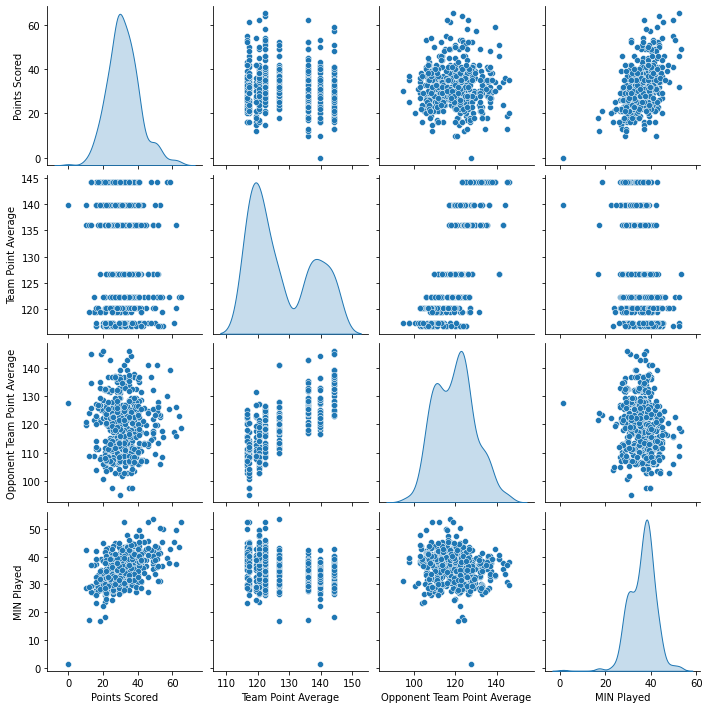

In [16]:
sns.pairplot(train_dataset[["Points Scored", "Team Point Average", "Opponent Team Point Average", "MIN Played"]], diag_kind="kde" )

In [17]:
train_stats = train_dataset.describe()
train_stats.pop("Points Scored")
train_stats = train_stats.transpose()
train_stats

#for this data this is not that informative but the mean gives a good impression of the number of times Damian Lillard had played the shown team

,count,mean,std,min,25%,50%,75%,max
MIN Played,490.0,36.274459,5.618035,1.550000,32.516667,37.041667,39.663333,53.533333
Team Point Average,490.0,127.562700,9.863554,116.707317,119.365854,122.353659,136.048780,144.195122
Opponent Team Point Average,490.0,119.661920,9.629757,94.924242,111.681818,119.987805,125.780488,146.182927
ATL,490.0,0.024490,0.154722,0.000000,0.000000,0.000000,0.000000,1.000000
BOS,490.0,0.018367,0.134413,0.000000,0.000000,0.000000,0.000000,1.000000
CHA,490.0,0.020408,0.141536,0.000000,0.000000,0.000000,0.000000,1.000000
CHI,490.0,0.022449,0.148290,0.000000,0.000000,0.000000,0.000000,1.000000
CLE,490.0,0.026531,0.160871,0.000000,0.000000,0.000000,0.000000,1.000000
DAL,490.0,0.044898,0.207292,0.000000,0.000000,0.000000,0.000000,1.000000
DEN,490.0,0.051020,0.220264,0.000000,0.000000,0.000000,0.000000,1.000000


In [18]:
train_labels = train_dataset.pop("Points Scored")
test_labels = test_dataset.pop("Points Scored")

In [19]:

def sigmoid(x):
    return(x - train_stats['mean'])/train_stats['std']
normed_train_data = sigmoid(train_dataset)
normed_test_data = sigmoid(test_dataset)


In [20]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [21]:
model = build_model()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


In [23]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.08974026],
       [-0.12132676],
       [-0.86452115],
       [-0.44778255],
       [-0.12921655],
       [-0.39524698],
       [-0.4413426 ],
       [-1.2836201 ],
       [-0.08919907],
       [-0.38900155]], dtype=float32)

In [24]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,14.568884,2.478435,14.568884,178.079041,10.338378,178.079041,995
996,13.503931,2.285254,13.503931,156.893372,9.848063,156.893372,996
997,12.771122,2.170105,12.771122,169.458206,10.112435,169.458206,997
998,12.634418,2.243227,12.634418,171.216797,10.155295,171.216797,998
999,14.766994,2.547040,14.766994,146.901733,9.558412,146.901733,999


In [26]:
import matplotlib.pyplot as plt 

def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [Points Scored]")
    plt.plot(hist['epoch'], hist['mae'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")

    plt.legend()
    #plt.ylim([0,5])


    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$Points Scored^2$]")
    plt.plot(hist['epoch'], hist['mse'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
    plt.legend()
    #plt.ylim([0,20])

#plot_history(history)


............

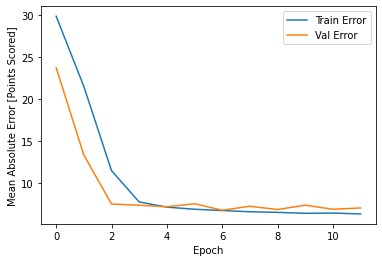

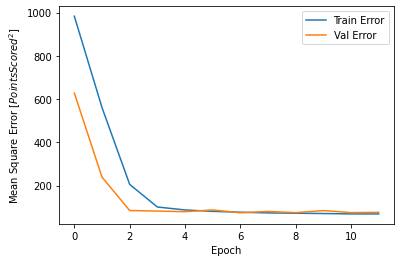

In [27]:
#early stopping

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))

Testing set Mean Abs Error:  6.32 Points Scored


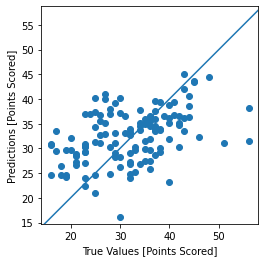

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Points Scored]")
plt.ylabel("Predictions [Points Scored]")
plt.axis('equal')
plt.axis('square')
#plt.xlim([0, plt.ylim()[1]])
#plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100, 100])